In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
import nltk
import tensorflow as tf
from math import log
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [2]:
# Load and preprocess dataset
data_path = "/Users/celinewu/Documents/GitHub/2024-25c-fai2-adsai-group-group16/Data/cropped_df.csv"
df = pd.read_csv(data_path)

# Drop missing or empty labels
df = df.dropna(subset=["main_category"])
df = df[df["main_category"].str.strip() != ""]

# rename main_category
df.rename(columns={"main_category": "label"}, inplace=True)


In [3]:
# Perform text augmentation
nltk.download('averaged_perceptron_tagger')
augmenter = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=2, aug_p=0.1)

def augment_data(df, text_col, label_col, augmenter):
    class_counts = df[label_col].value_counts()
    max_samples = class_counts.max()
    augmented_data = []
    
    for label, count in class_counts.items():
        label_df = df[df[label_col] == label]
        augmented_data.append(label_df)
        
        if count < max_samples:
            additional_samples = max_samples - count
            sampled_df = label_df.sample(n=additional_samples, replace=True, random_state=42)
            augmented_texts = [augmenter.augment(text) if text else text for text in sampled_df[text_col]]
            augmented_df = pd.DataFrame({text_col: augmented_texts, label_col: label})
            augmented_data.append(augmented_df)
    
    return pd.concat(augmented_data, axis=0).reset_index(drop=True)

balanced_df = augment_data(df, "text", "label", augmenter)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/celinewu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(balanced_df["label"])
num_classes = len(label_encoder.classes_)

# Tokenization and padding
max_words = 10000
max_seq_len = 30

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df["text"])

X_sequences = tokenizer.texts_to_sequences(balanced_df["text"])
X_padded = pad_sequences(X_sequences, maxlen=max_seq_len, padding='post')


In [5]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights
class_weights = {label: log(1 + (len(y_train) / (num_classes * count))) for label, count in zip(*np.unique(y_train, return_counts=True))}


In [6]:
# Define RNN model
embedding_dim = 128
rnn_units = 128
dropout_prob = 0.5

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_seq_len),
    SimpleRNN(rnn_units, return_sequences=True, activation='relu'),
    Dropout(dropout_prob),
    SimpleRNN(rnn_units, activation='relu'),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax')
])


/Users/celinewu/anaconda3/envs/2B/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-19 13:40:34.429026: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-03-19 13:40:34.429046: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-19 13:40:34.429050: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-19 13:40:34.429067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-19 13:40:34.429078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefin

In [7]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_seq_len))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,346,695 (5.14 MB)

 Trainable params: 1,346,695 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('rnn_emotion_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/35


2025-03-19 13:40:34.946756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1011s 870ms/step - accuracy: 0.2411 - loss: 1.1755 - val_accuracy: 0.3024 - val_loss: 1.4644
Epoch 2/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1086s 936ms/step - accuracy: 0.3400 - loss: 1.0016 - val_accuracy: 0.3390 - val_loss: 1.3732
Epoch 3/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1550s 1s/step - accuracy: 0.4275 - loss: 0.8968 - val_accuracy: 0.6050 - val_loss: 1.0853
Epoch 4/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1123s 968ms/step - accuracy: 0.5895 - loss: 0.7326 - val_accuracy: 0.6904 - val_loss: 0.9085
Epoch 5/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1366s 1s/step - accuracy: 0.6057 - loss: 0.7312 - val_accuracy: 0.7034 - val_loss: 0.8629
Epoch 6/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1172s 1s/step - accuracy: 0.6985 - loss: 0.5820 - val_accuracy: 0.6708 - val_loss: 0.9035
Epoch 7/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1182s 1s/step - accuracy: 0.7227 - loss: 0.5432 - val_accuracy: 0.6656 - val_loss: 0.9247
Epoch 8/35
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1144s 986ms/step - accuracy: 0.7269 

In [9]:
# Evaluate model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

y_preds = np.argmax(model.predict(X_val), axis=1)
f1_macro = f1_score(y_val, y_preds, average='macro')
print(f"Macro F1 Score: {f1_macro:.4f}")


290/290 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.7377 - loss: 0.7761
Validation Loss: 0.8018
Validation Accuracy: 0.7434
290/290 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step
Macro F1 Score: 0.7353


In [10]:
# Display classification report
print("Classification Report:\n", classification_report(y_val, y_preds, target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

       anger       0.95      0.70      0.81      1325
     disgust       0.98      0.99      0.99      1325
        fear       0.84      0.70      0.76      1325
   happiness       0.60      0.75      0.67      1325
     neutral       0.59      0.98      0.74      1325
     sadness       0.67      0.75      0.70      1325
    surprise       0.87      0.33      0.48      1325

    accuracy                           0.74      9275
   macro avg       0.79      0.74      0.74      9275
weighted avg       0.79      0.74      0.74      9275



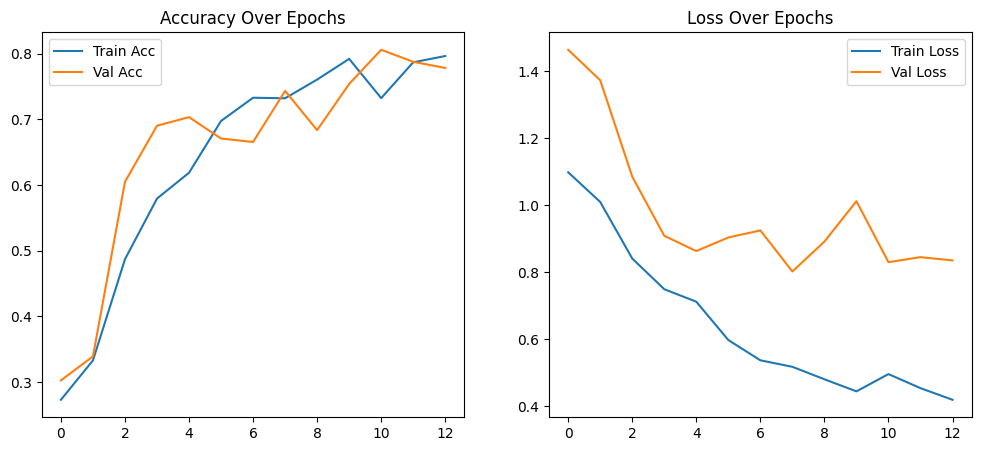

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

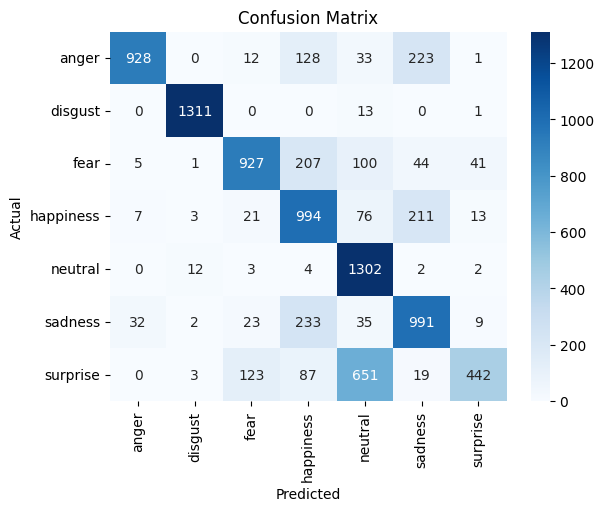

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()